# Packages 
**Installing and importing our required packages**


In [ ]:
!pip install --upgrade nibabel>=3.2
!pip install nilearn

import numpy as np
import nibabel as nb

from nilearn import plotting 
from nilearn import datasets 
from nilearn.image import mean_img
from nilearn.plotting import plot_img 
import matplotlib.pyplot as plt
import pandas as pd
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 17.3 MB/s eta 0:00:00


# Mounting drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Colab Notebooks/data/python_project/'
os.chdir(folder_path)

Mounted at /content/drive


# Loading behavioual data

We have four trial types: 
1.   Standard 0 (st0) = this is the 1st standard of the run
2.   Standard 1 (st1) = this is the 2nd standard of the run
3.   Standard 2 (st2) = this is the 3rd standard of the run
4.   Deviant (dev) = this is the deviant 

Note: the experimental design consists of 8 tones. All tones will sound the same, except for one deviant, which could be placed in the 4th, 5th, or 6th position. 

For simplicity, I have collapsed the deviants into one type (dev), and am interested in the contrast between deviants and standards in relation to subcortical (inferior colliculus, medial geniculate body) and cortical activation (primary and secondary auditory cortex). 

So, our our contrast conditions will look like: <br>

Cond1: Deviant > Standard 1 

Cond2: Deviant > Standard 2 

In [ ]:
#setting the file path using string formatting
subject = 1
run_number = 1
behavioural_path = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub{}/behavioural/run{}.csv'.format(subject, run_number)

#read the CSV file using pandas
events_df = pd.read_csv(behavioural_path)

print(events_df)

          onset  duration trial_type
0      0.000623      0.25        st0
1     35.434449      0.25        st0
2     44.535469      0.25        st0
3     53.619482      0.25        st0
4     64.837385      0.25        st0
..          ...       ...        ...
427  467.152076      0.25        dev
428  476.254331      0.25        dev
429  485.353334      0.25        dev
430  504.985955      0.25        dev
431  550.753144      0.25        dev

[432 rows x 3 columns]


In [ ]:
print(events_df)

          onset  duration trial_type
0      0.000623      0.25        st0
1     35.434449      0.25        st0
2     44.535469      0.25        st0
3     53.619482      0.25        st0
4     64.837385      0.25        st0
..          ...       ...        ...
427  467.152076      0.25        dev
428  476.254331      0.25        dev
429  485.353334      0.25        dev
430  504.985955      0.25        dev
431  550.753144      0.25        dev

[432 rows x 3 columns]


# Functional data
in native space.

In [ ]:
func = nb.load('/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/functional/mean.nii')
anat = nb.load('/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/functional/anatomical.nii')

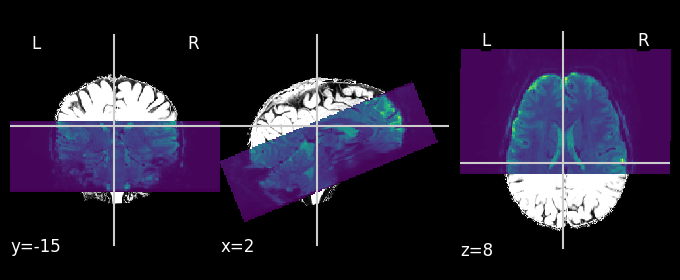

In [ ]:
display = plotting.plot_anat(anat, display_mode='ortho', dim=-1)
display.add_overlay(func)

in MNI space.

In [ ]:
func_sub01 = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/functional/run1/swauf.nii' #smoothed and normalized
example = nb.load(func_sub01) 

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



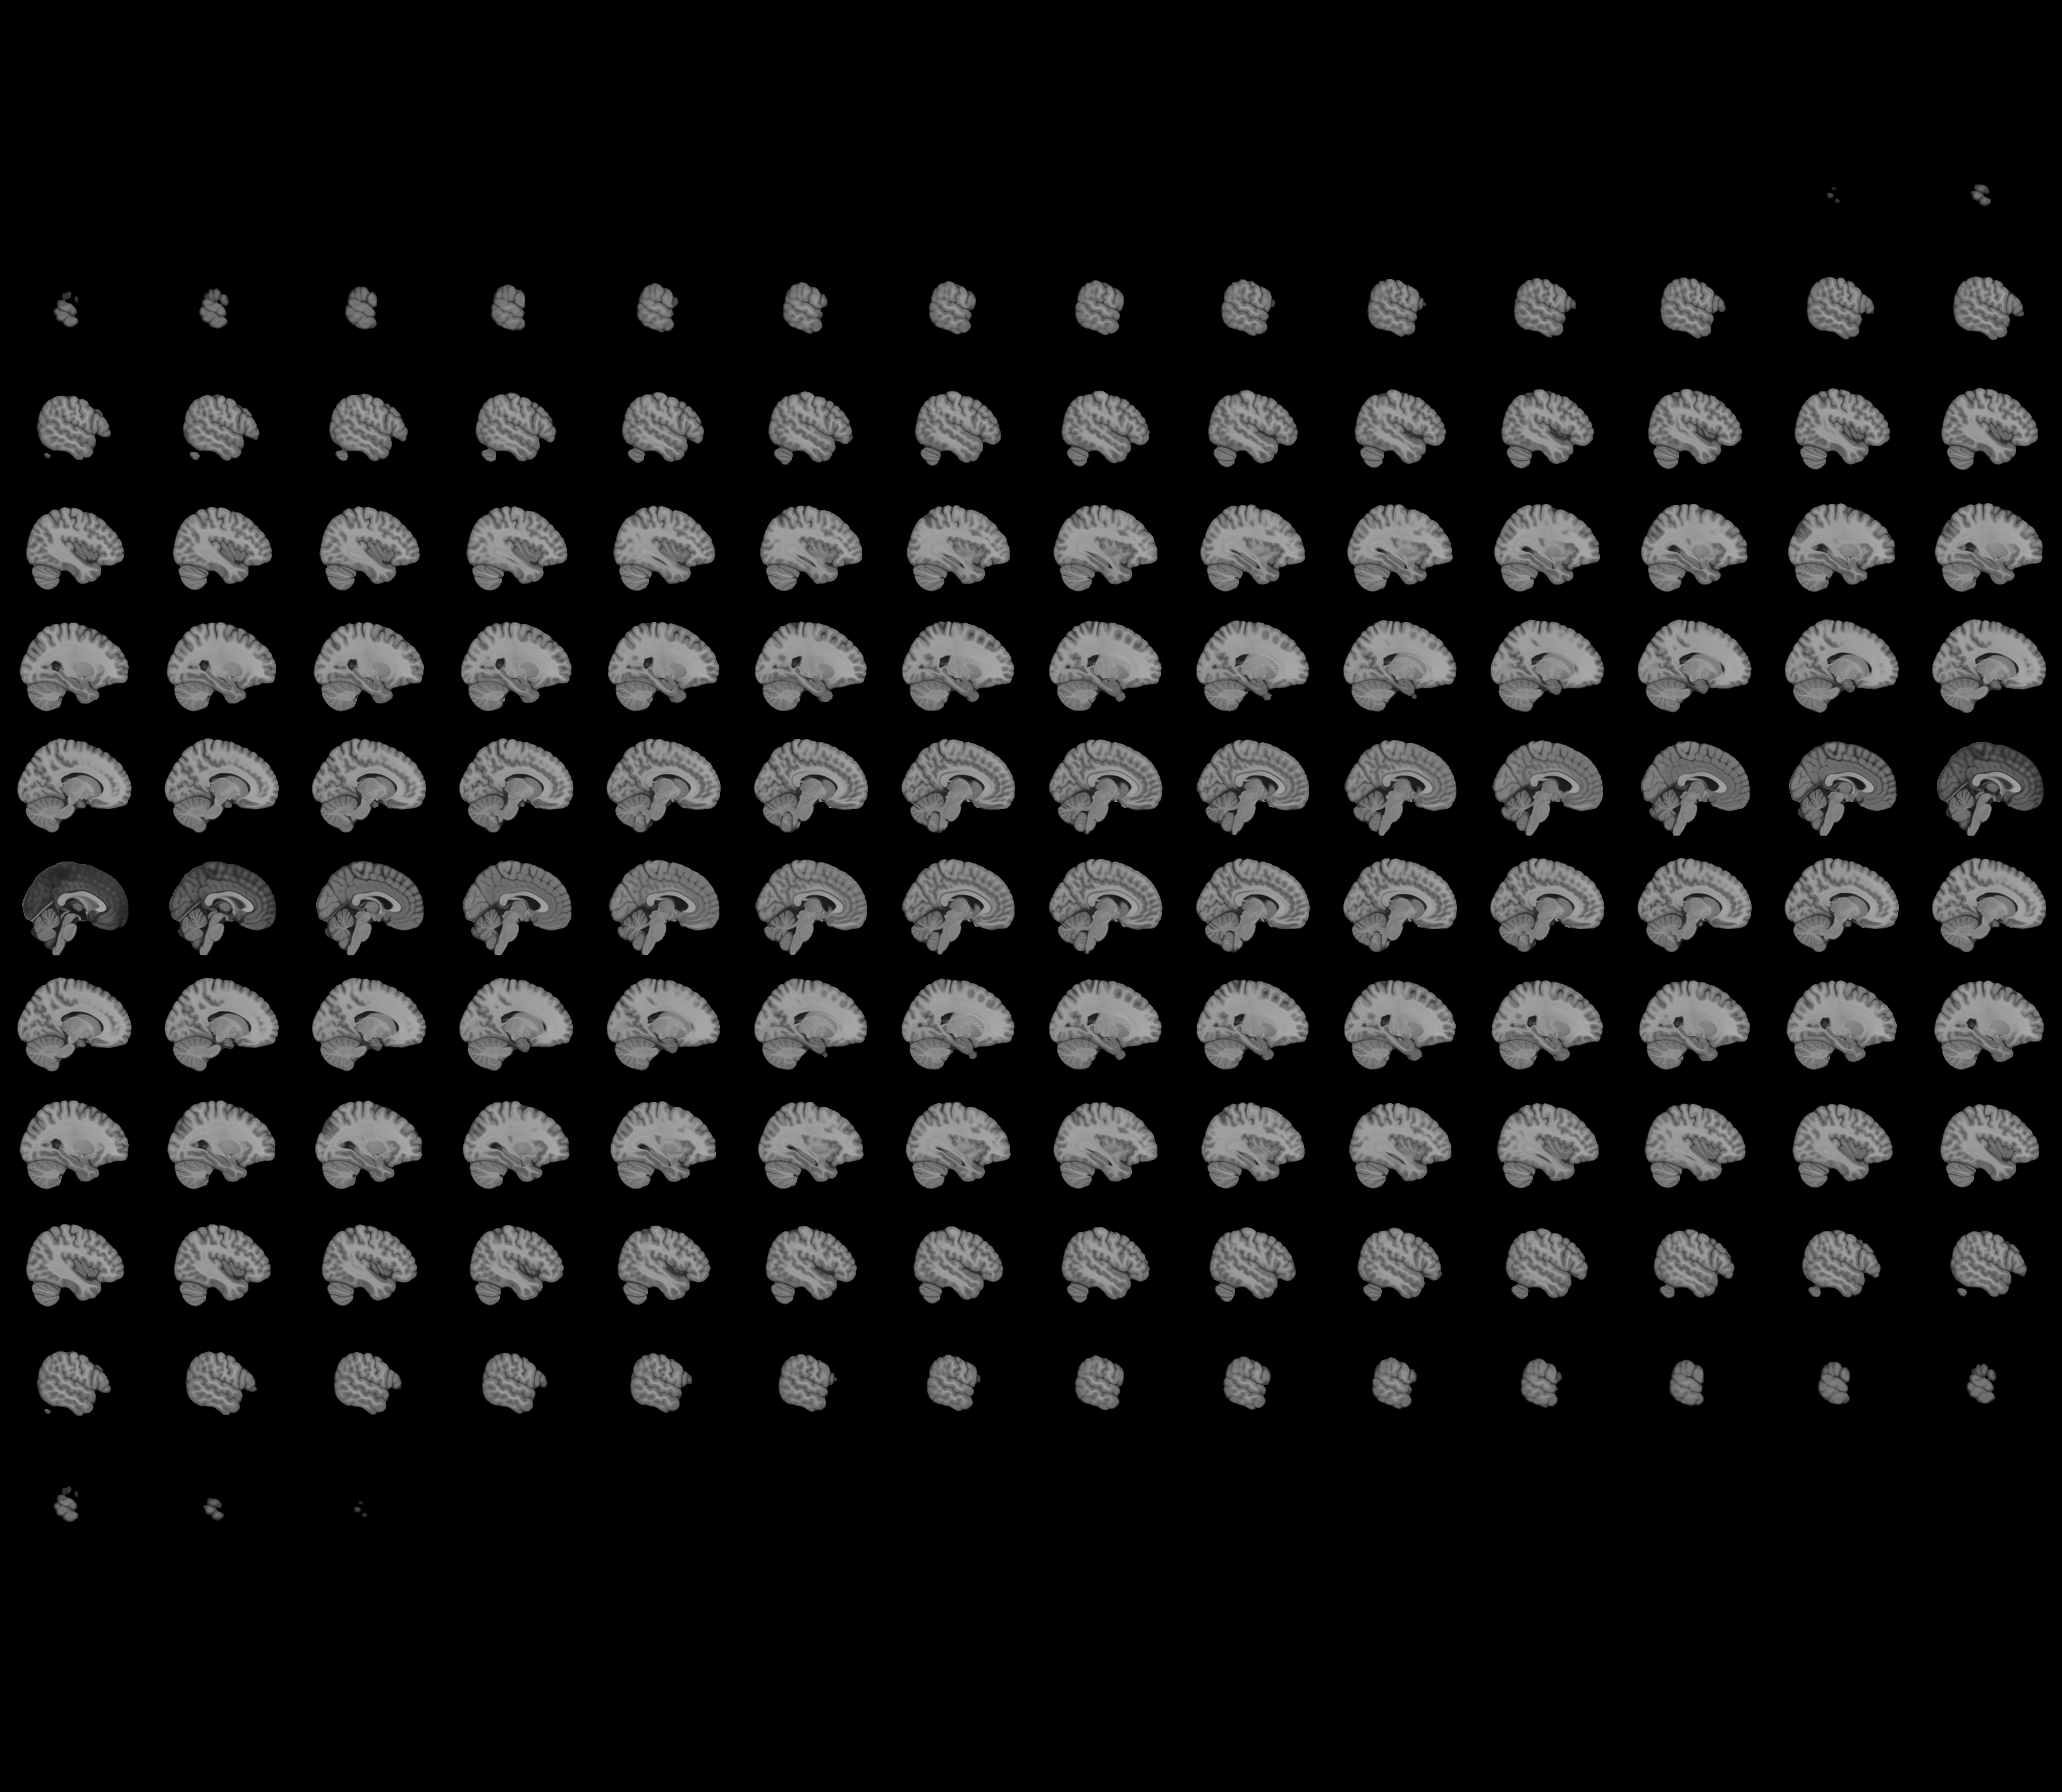
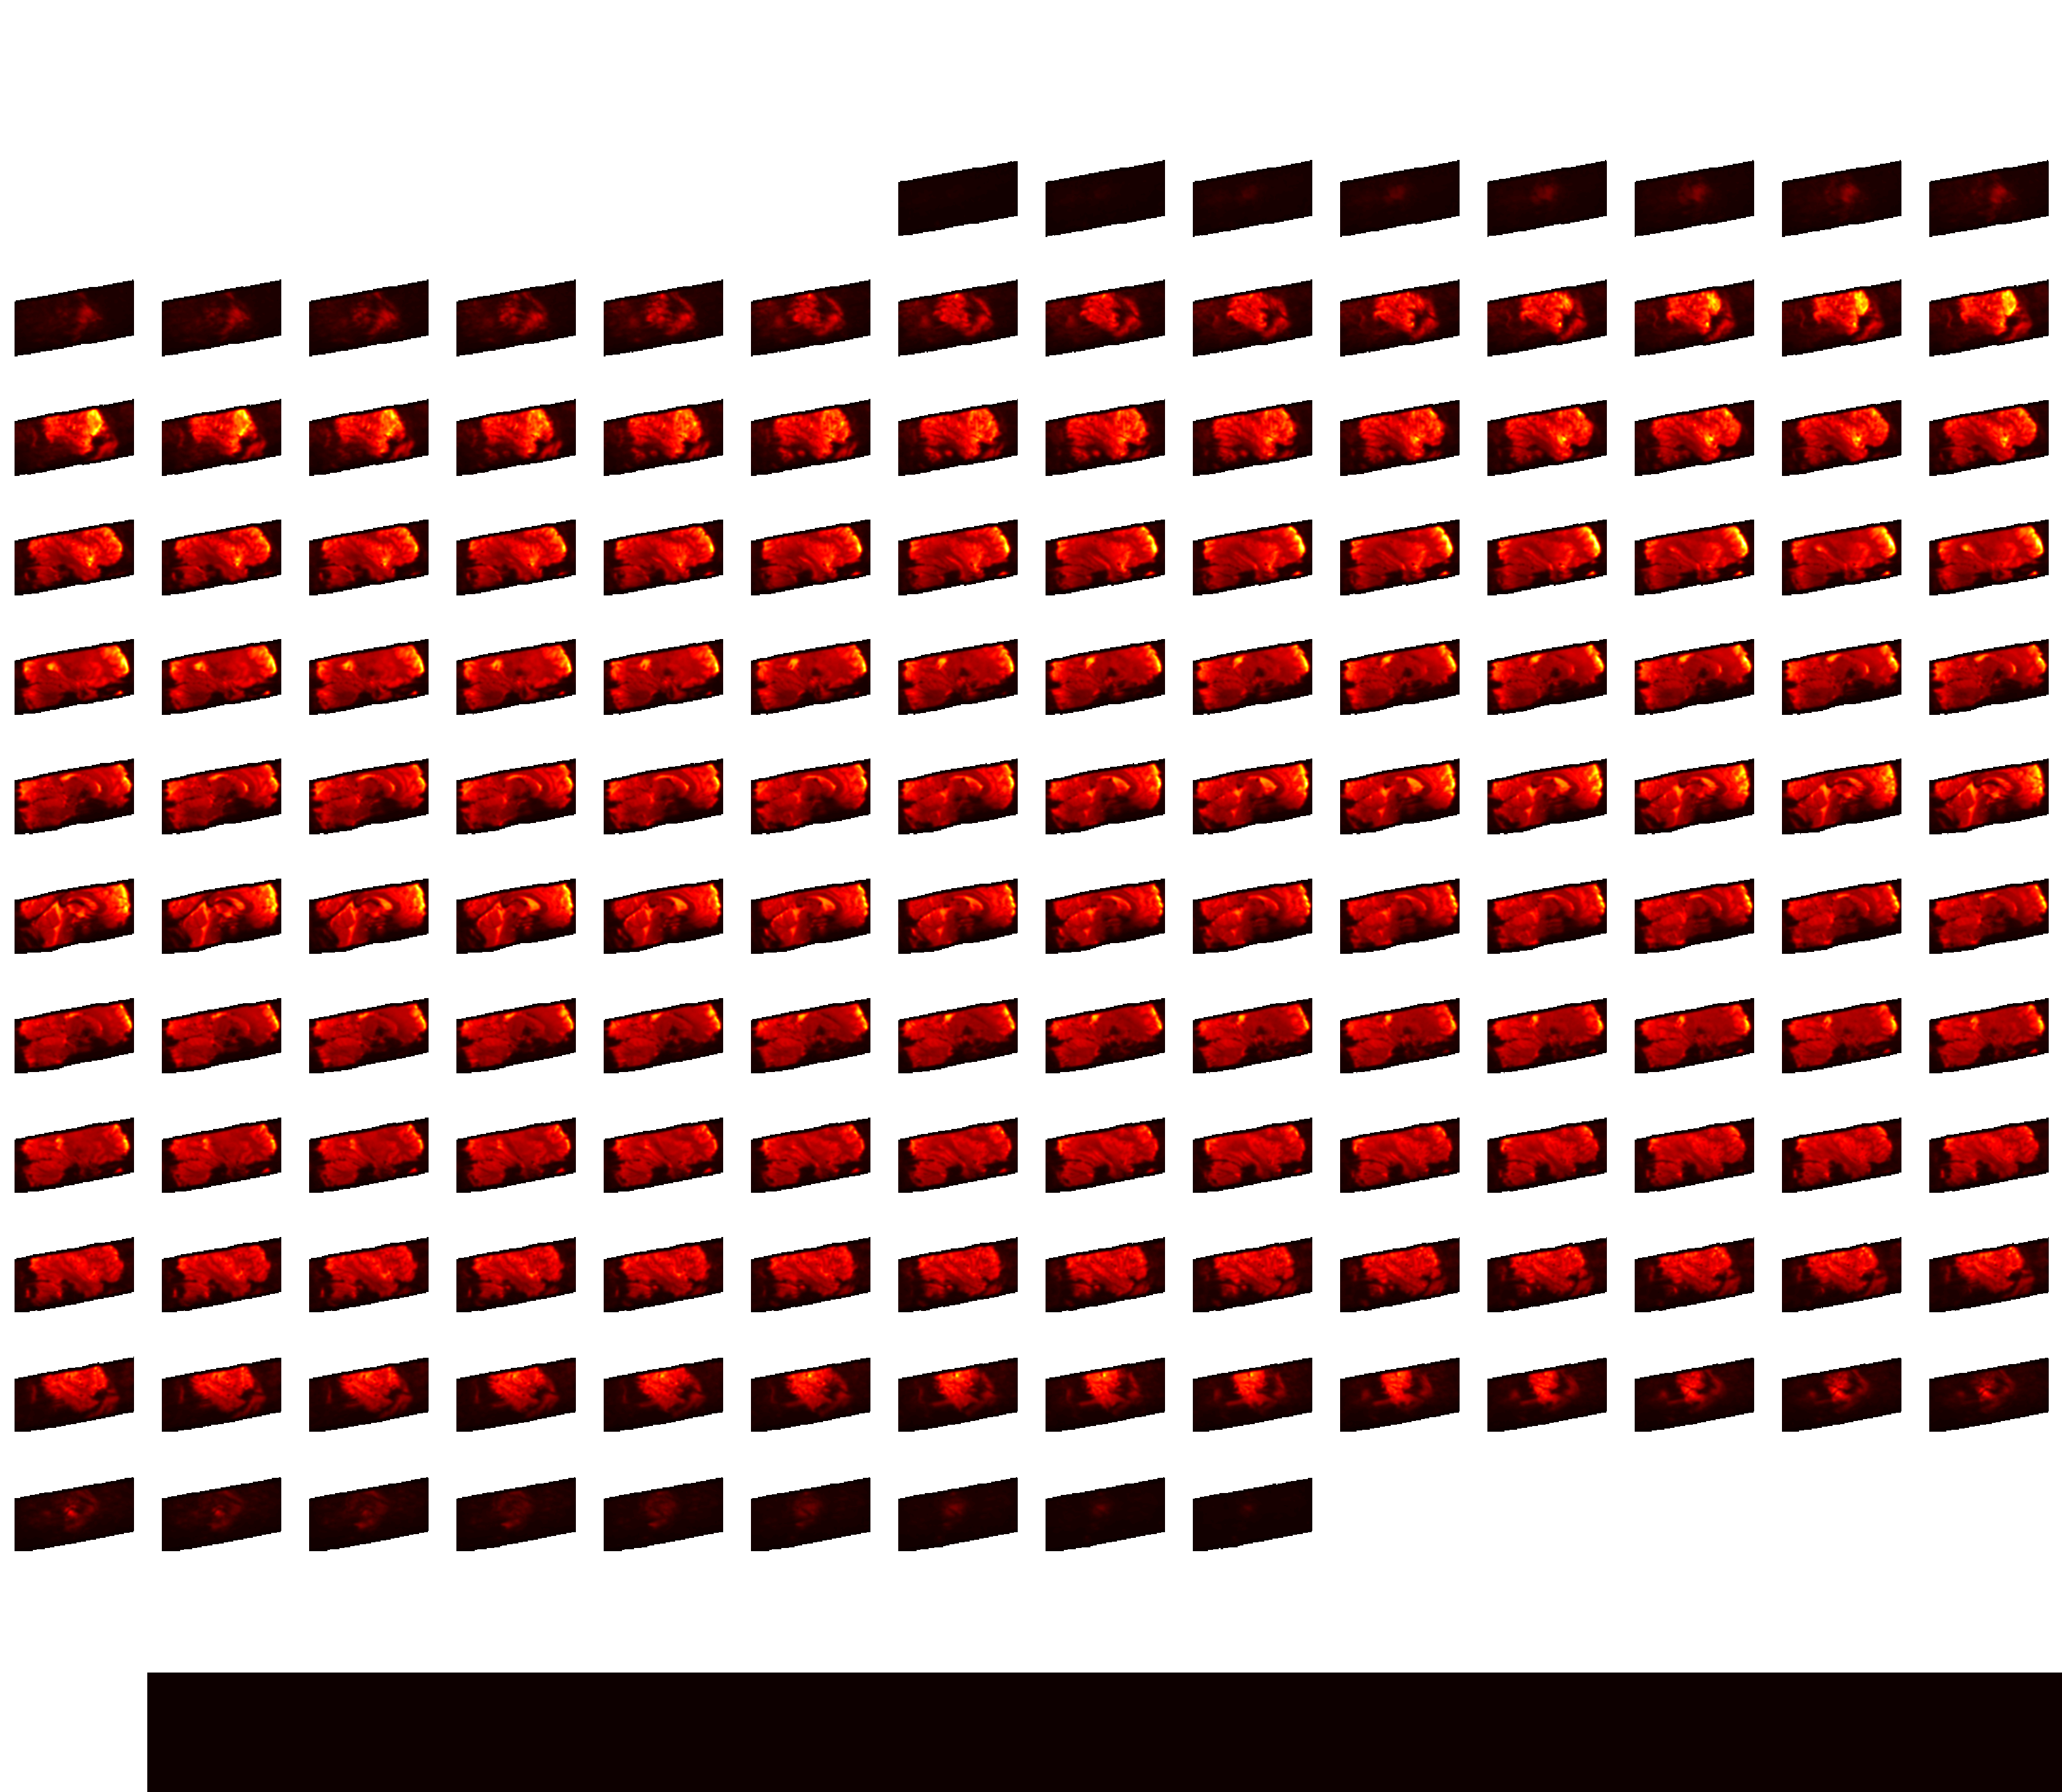

In [ ]:
plotting.view_img(example)

# Loading ROI masks

We are doing a region of interest study:
1. inferior colliculus 
2. medial geniculate body 
3. primary auditory cortex 
4. secondary auditory cortex 

Thus, we have 2 subcortical and 2 cortical regions. I have created the ROIs in native space via the MarsBar toolbox on SPM. Let's load them. 

**Important note**: I had lots of troubleshooting with concat my 4 runs into one. I tried concat images in pairs, and while that worked to create an image, it was impossible to run the rest of the code without it crashing at some point. Thus, I have decided to treat each run as its own seperate participant. 

In [ ]:
from nilearn import plotting as npl
from nilearn.input_data import NiftiLabelsMasker

IC = nb.load('/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/rois/winferior colliculus.nii') 
MGB = nb.load('/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/rois/wmedial geniculate body.nii') 
PAC = nb.load('/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/rois/wprimary auditory cortex.nii') 
SAC = nb.load('/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/rois/wsecondary auditory cortex.nii') 

/usr/local/lib/python3.9/dist-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [ ]:
mask_ic = NiftiLabelsMasker(IC, standardize=False)
mask_mgb = NiftiLabelsMasker(MGB, standardize=False)
mask_pac = NiftiLabelsMasker(PAC, standardize=False)
mask_sac = NiftiLabelsMasker(SAC, standardize=False)

mask_ic.fit(anat)
report_ic = mask_ic.generate_report()

mask_pac.fit(anat)
report_pac = mask_pac.generate_report()

mask_sac.fit(anat)
report_sac = mask_sac.generate_report()

In [ ]:
#IC
report_ic

In [ ]:
#PAC
report_pac

In [ ]:
#SAC
report_sac

# **ROI First Level Models**

In [ ]:
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix, run_glm
from nilearn.plotting import plot_design_matrix
from nilearn.glm.contrasts import compute_contrast

# Subject 1 (aka Run 1)

**Loading functional run 1**

In [ ]:
img = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/functional/run1/4D.nii'

**Loading behavioural run 1**

In [ ]:
behavioural_path = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/behavioural/run1.csv'
events_df = pd.read_csv(behavioural_path)

**IC (subject 1)**

In [ ]:
masker = NiftiLabelsMasker(IC, standardize=False)

ic_1 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(ic_1)[0]),events=events_df)

labels,estimates = run_glm(ic_1,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

**masker = NiftiLabelsMasker(IC, standardize=False):** this applies our mask to our nifti image file (4D run 1). 

**ic_1 = masker.fit_transform(img):** this applies the mask to the nifti image, and returns a 2D array (ic_1) containing the masked data. each row of ic_1 represents a different time point, and each column represents the average signal intensity for that time point. 

**design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(ic_1)[0]),events=events_df):** this line of code creates our first level model, fitting in the events for subject 1

**labels,estimates = run_glm(ic_1,design_matrix.values):** this line of code runs a GLM analysis on the masked data (ic_1) using the design matrix.output returns two variables: *labels*, which is a list of the names of the columns in the design matrix, and *estimates*, which is a 2D array containing the parameter estimates for each column of the design matrix




In [ ]:
print(ic_1.shape)

(499, 1)


If we print ic_1, we see that our array contains 499 volumes and 1 value for each volume, corresponding to the average signal intensity for that particular time point

**Plotting design matrix**

<Axes: label='conditions', ylabel='scan number'>

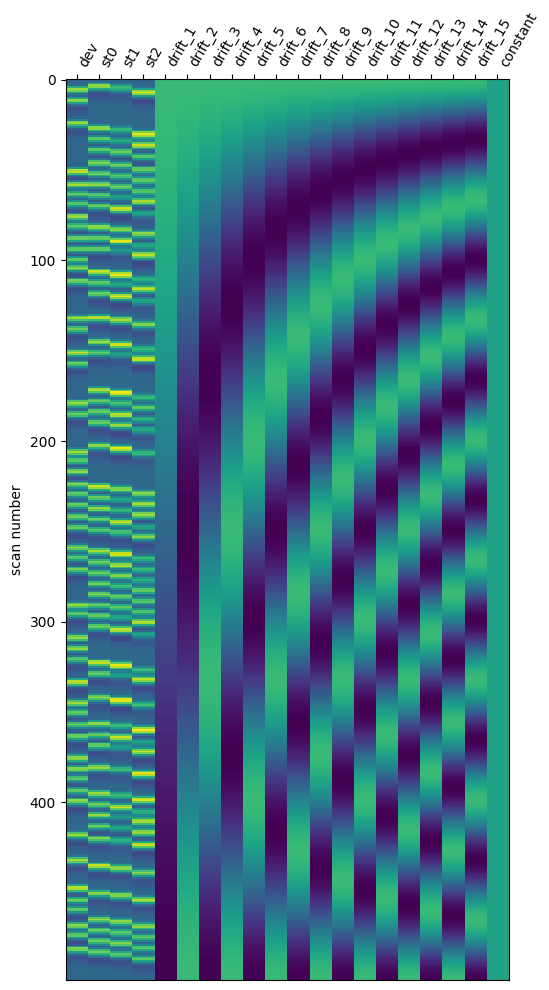

In [ ]:
plot_design_matrix(design_matrix)

In [ ]:
#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("z-value (dev>st2):", cond2.z_score())

z-value (dev>st1): [2.3929163]
z-value (dev>st2): [1.8505184]


**MGB (run 1)**

In [ ]:
masker = NiftiLabelsMasker(MGB, standardize=False)

mgb_1 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(mgb_1)[0]),events=events_df)

labels,estimates = run_glm(mgb_1,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [0.10236171]
p-value (dev>st1): [0.45923479]
z-value (dev>st2): [0.89055333]
p-value (dev>st2): [0.18658442]


**PAC (run 1)**

In [ ]:
masker = NiftiLabelsMasker(PAC, standardize=False)

pac_1 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(pac_1)[0]),events=events_df)

labels,estimates = run_glm(pac_1,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [-2.97092706  1.01561165]
p-value (dev>st1): [0.99851549 0.15490718]
z-value (dev>st2): [-0.82980477  0.85628569]
p-value (dev>st2): [0.79667541 0.19591989]


**SAC (run 1)**

In [ ]:
masker = NiftiLabelsMasker(SAC, standardize=False)

sac_1 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(sac_1)[0]),events=events_df)

labels,estimates = run_glm(sac_1,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [-3.11566451  0.8696889 ]
p-value (dev>st1): [0.99908235 0.19223522]
z-value (dev>st2): [-0.40724863  0.23752835]
p-value (dev>st2): [0.65808731 0.40612346]


To summarize these values: 
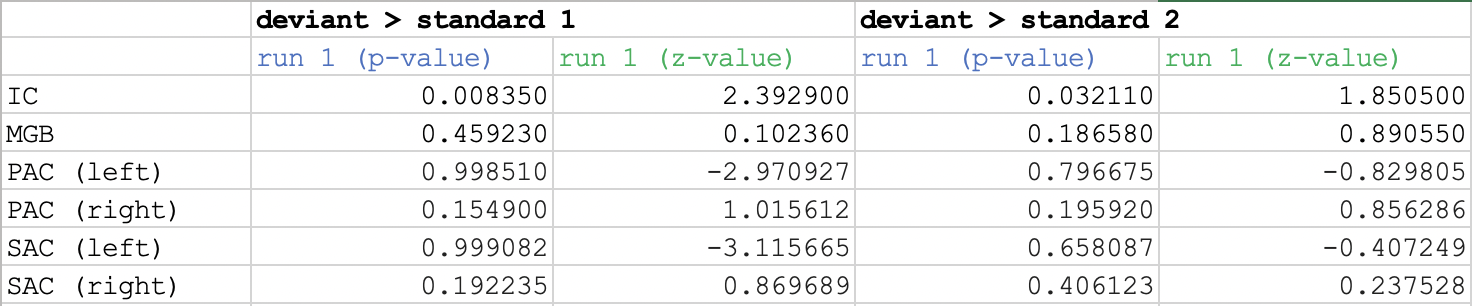


# Subject 2 (aka Run 2)

**Loading run 2**

In [ ]:
img = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/functional/run2/4D.nii'

In [ ]:
behavioural_path = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/behavioural/run2.csv'
events_df = pd.read_csv(behavioural_path)
print(events_df)

          onset  duration trial_type
0      0.000389      0.25        st0
1      9.163264      0.25        st0
2     27.363850      0.25        st0
3     69.262874      0.25        st0
4     78.348359      0.25        st0
..          ...       ...        ...
427  467.152076      0.25        dev
428  476.254331      0.25        dev
429  485.353334      0.25        dev
430  504.985955      0.25        dev
431  550.753144      0.25        dev

[432 rows x 3 columns]


**IC (run 2)**

In [ ]:
masker = NiftiLabelsMasker(IC, standardize=False)

ic_2 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(ic_2)[0]),events=events_df)

labels,estimates = run_glm(ic_2,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

<Axes: label='conditions', ylabel='scan number'>

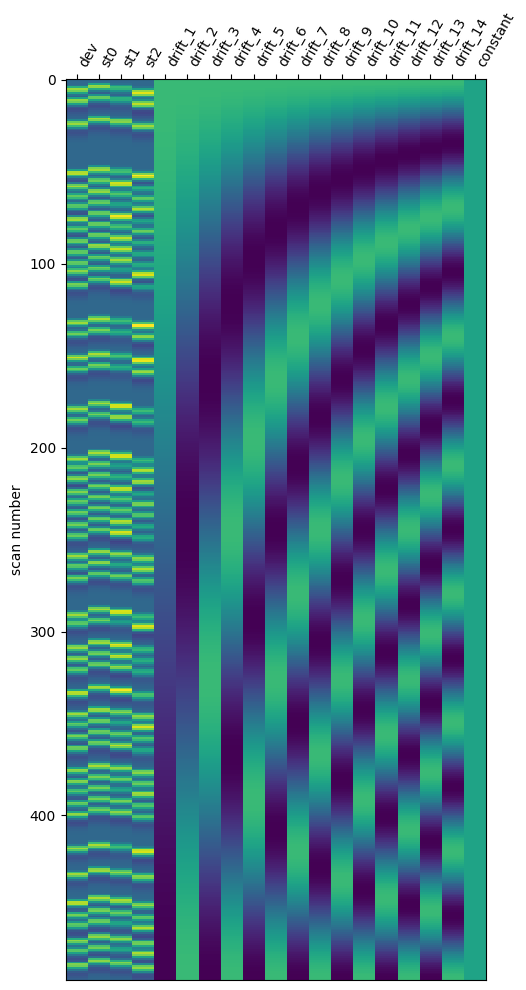

In [ ]:
plot_design_matrix(design_matrix)

In [ ]:
#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [-0.21190584]
p-value (dev>st1): [0.58390975]
z-value (dev>st2): [0.17142766]
p-value (dev>st2): [0.43194375]


**MGB (run 2)**

In [ ]:
masker = NiftiLabelsMasker(MGB, standardize=False)

mgb_2 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(mgb_2)[0]),events=events_df)

labels,estimates = run_glm(mgb_2,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [0.54564917]
p-value (dev>st1): [0.29265356]
z-value (dev>st2): [1.26258613]
p-value (dev>st2): [0.10336898]


**PAC (run 2)**



In [ ]:
masker = NiftiLabelsMasker(PAC, standardize=False)

pac_2 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(pac_2)[0]),events=events_df)

labels,estimates = run_glm(pac_2,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [-0.53529935  1.25982366]
p-value (dev>st1): [0.70377856 0.10386649]
z-value (dev>st2): [0.78156264 0.87716385]
p-value (dev>st2): [0.21723583 0.19019882]


**SAC (run 2)**

In [ ]:
masker = NiftiLabelsMasker(SAC, standardize=False)

sac_1 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(sac_1)[0]),events=events_df)

labels,estimates = run_glm(sac_1,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')
#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [-0.50406654 -1.77768909]
p-value (dev>st1): [0.69289269 0.96227253]
z-value (dev>st2): [ 1.19765887 -1.6687172 ]
p-value (dev>st2): [0.11552492 0.95241328]


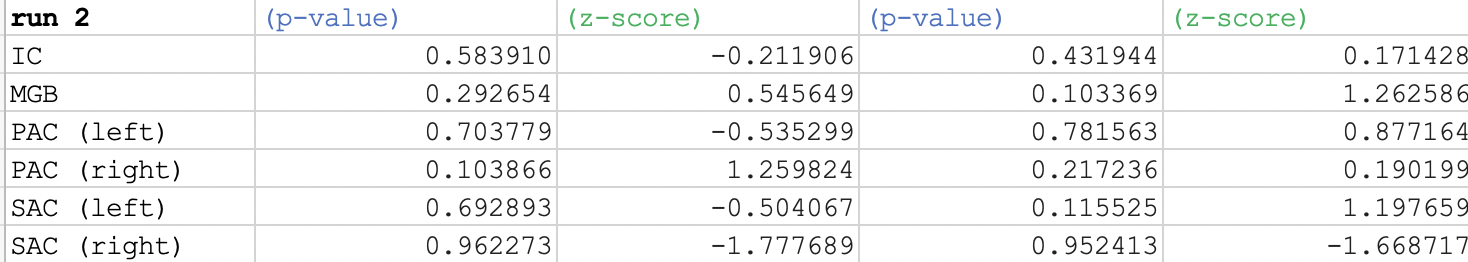

# Subject 3 (aka run 3)

**Loading run 3**

In [ ]:
img = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/functional/run3/4D.nii'

In [ ]:
behavioural_path = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/behavioural/run3.csv'
events_df = pd.read_csv(behavioural_path)

**IC (run 3)**

In [ ]:
masker = NiftiLabelsMasker(IC, standardize=False)

ic_3 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(ic_3)[0]),events=events_df)

labels,estimates = run_glm(ic_3,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

<Axes: label='conditions', ylabel='scan number'>

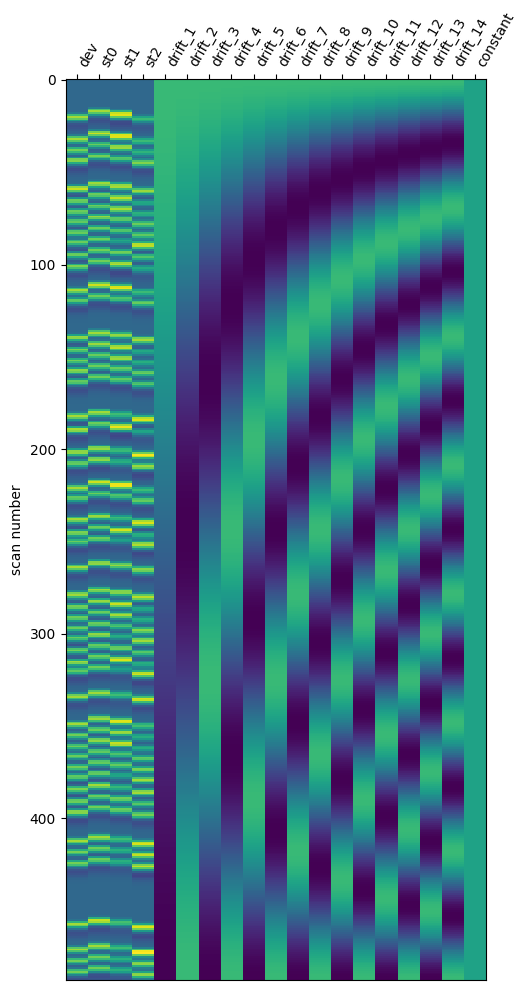

In [ ]:
plot_design_matrix(design_matrix)

In [ ]:
#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [-0.41054503]
p-value (dev>st1): [0.65929691]
z-value (dev>st2): [-0.80504092]
p-value (dev>st2): [0.78960197]


**MGB (run 3)**

In [ ]:
masker = NiftiLabelsMasker(MGB, standardize=False)

mgb_3 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(mgb_3)[0]),events=events_df)

labels,estimates = run_glm(mgb_3,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [0.65664078]
p-value (dev>st1): [0.25570596]
z-value (dev>st2): [0.25260299]
p-value (dev>st2): [0.40028751]


**PAC (run 3)**

In [ ]:
masker = NiftiLabelsMasker(PAC, standardize=False)

pac_3 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(pac_3)[0]),events=events_df)

labels,estimates = run_glm(pac_3,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [1.08292957 0.46636382]
p-value (dev>st1): [0.13941984 0.32047755]
z-value (dev>st2): [0.81126069 0.588912  ]
p-value (dev>st2): [0.20860799 0.27796015]


**SAC (run 3)**

In [ ]:
masker = NiftiLabelsMasker(SAC, standardize=False)

sac_3 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(sac_3)[0]),events=events_df)

labels,estimates = run_glm(sac_3,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [0.78699161 0.25546877]
p-value (dev>st1): [0.21564339 0.39918053]
z-value (dev>st2): [ 1.20930752 -0.02853554]
p-value (dev>st2): [0.11327236 0.51138249]


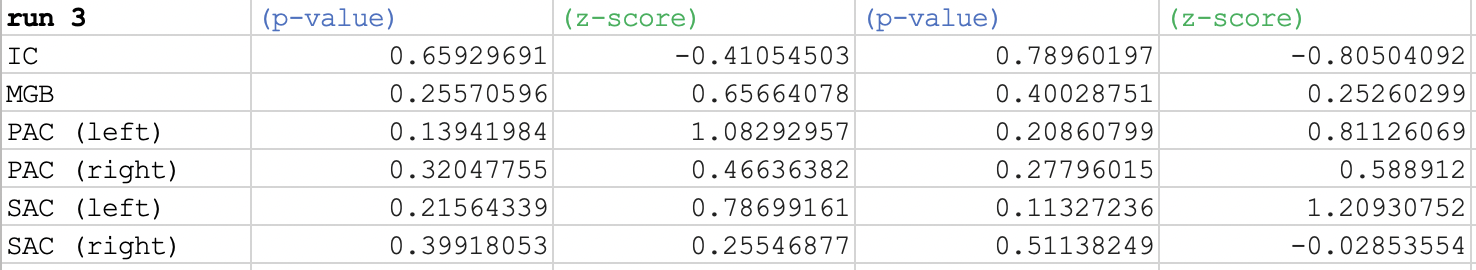

# Subject 4 (aka run 4)

**Loading run 4**

In [ ]:
img = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/functional/run4/4D.nii'

In [ ]:
behavioural_path = '/content/drive/MyDrive/Colab Notebooks/data/python_project/sub1/behavioural/run4.csv'
events_df = pd.read_csv(behavioural_path)

**IC (run 4)**

In [ ]:
masker = NiftiLabelsMasker(IC, standardize=False)

ic_4 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(ic_4)[0]),events=events_df)

labels,estimates = run_glm(ic_4,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

<Axes: label='conditions', ylabel='scan number'>

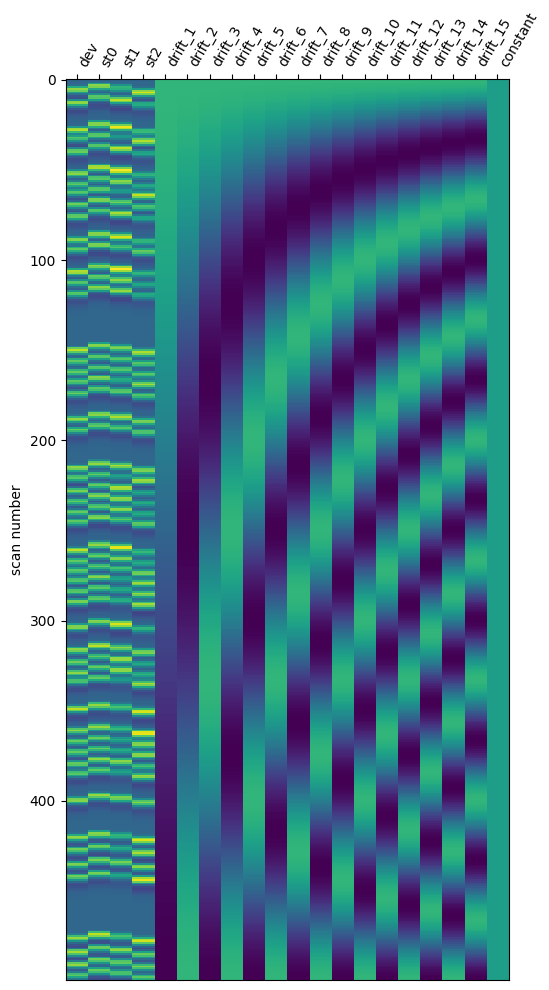

In [ ]:
plot_design_matrix(design_matrix)

In [ ]:
#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [0.14103284]
p-value (dev>st1): [0.443922]
z-value (dev>st2): [0.07800031]
p-value (dev>st2): [0.4689139]


**MGB (run 4)**

In [ ]:
masker = NiftiLabelsMasker(MGB, standardize=False)

mgb_4 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(mgb_4)[0]),events=events_df)

labels,estimates = run_glm(mgb_4,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [-0.45269362]
p-value (dev>st1): [0.67461531]
z-value (dev>st2): [-0.31121292]
p-value (dev>st2): [0.62218062]


**PAC (run 4)**

In [ ]:
masker = NiftiLabelsMasker(PAC, standardize=False)

pac_4 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(pac_4)[0]),events=events_df)

labels,estimates = run_glm(pac_4,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("z-value (dev>st2):", cond2.z_score())


NameError: ignored

**SAC (run 4)**

In [ ]:
masker = NiftiLabelsMasker(SAC, standardize=False)

sac_4 = masker.fit_transform(img) 

design_matrix = make_first_level_design_matrix(1.53*np.arange(np.shape(sac_4)[0]),events=events_df)

labels,estimates = run_glm(sac_4,design_matrix.values)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                       for i, column in enumerate(design_matrix.columns)])

#dev>st1
cond1=compute_contrast(labels,estimates,np.array([1., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

#dev>st2
cond2=compute_contrast(labels,estimates,np.array([1., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),contrast_type='t')

print("z-value (dev>st1):", cond1.z_score())
print("p-value (dev>st1):", cond1.p_value())
print("z-value (dev>st2):", cond2.z_score())
print("p-value (dev>st2):", cond2.p_value())

z-value (dev>st1): [0.72705714 0.49140582]
p-value (dev>st1): [0.23359548 0.31156972]
z-value (dev>st2): [1.54224724 0.69695541]
p-value (dev>st2): [0.06150676 0.24291535]


Here is what we've got: 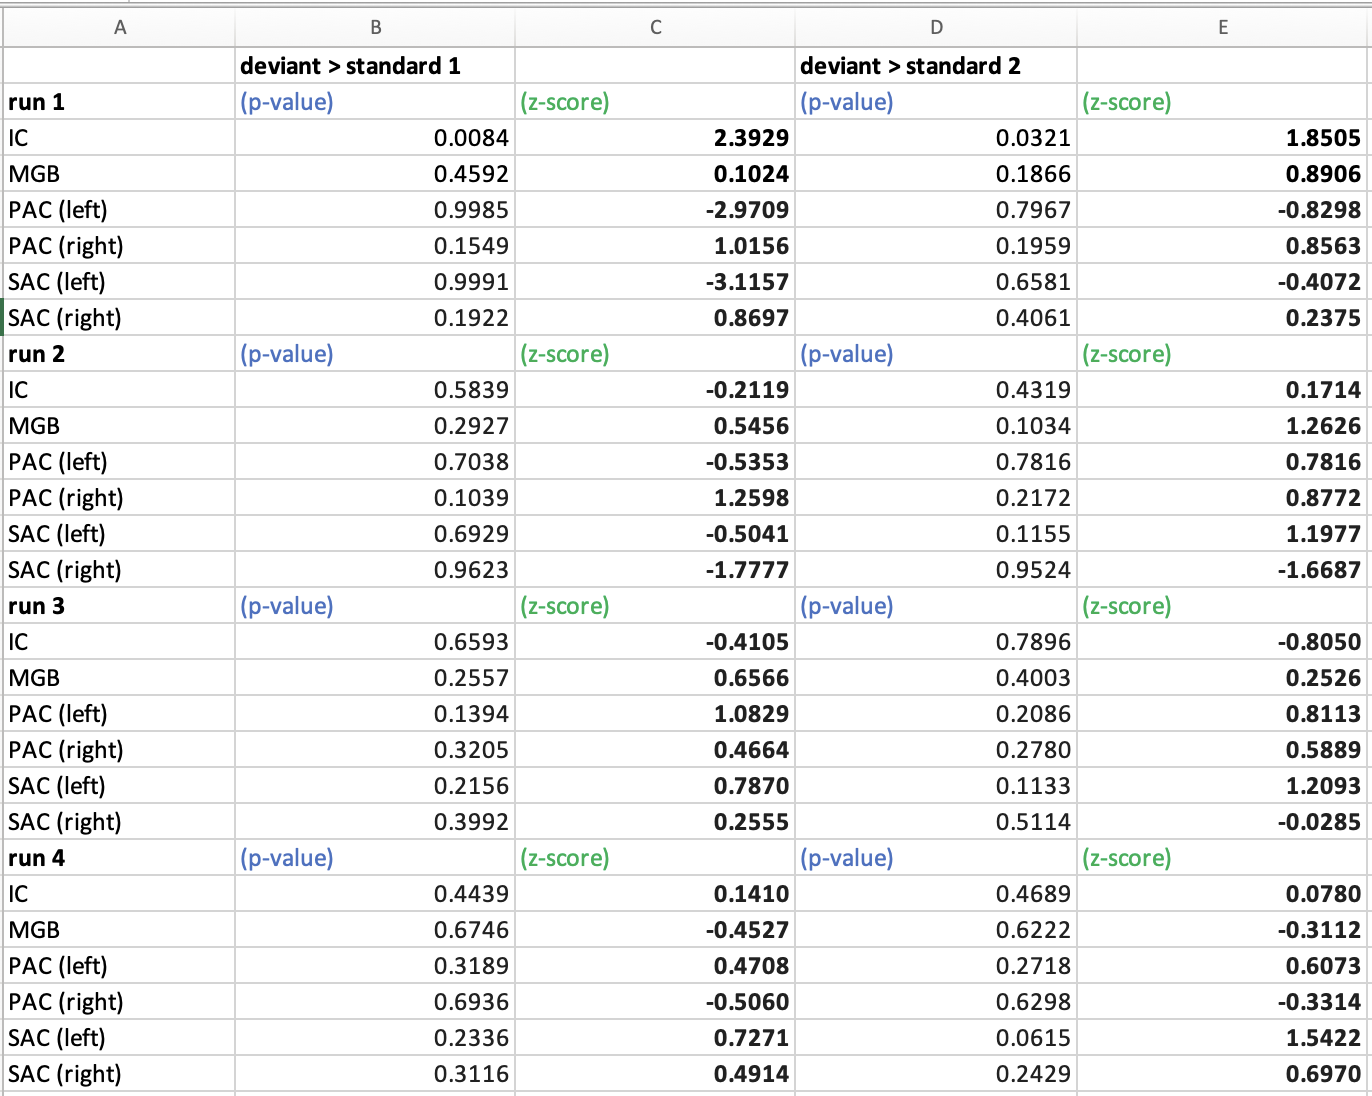

We are interested in the z-scores. 

# Group analyses: IC

In [1]:
import numpy as np
from scipy.stats import ttest_1samp

dev > standard 1:

In [ ]:
ic_z_scores = np.array([2.3929, -0.2119, -0.4105, 0.1410])

t_value, p_value = ttest_1samp(ic_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: 0.7369528347319231
p-value dev > std 1: 0.5145533318415124


dev > standard 2:

In [ ]:
ic_z_scores = np.array([1.8505, 0.1714, -0.8050, -0.0780])

t_value, p_value = ttest_1samp(ic_z_scores, popmean=0)

print("t-value dev > std 2:", t_value)
print("p-value dev > std 2:", p_value)

t-value dev > std 2: 0.5070673971527405
p-value dev > std 2: 0.6470308676701301


# Group analyses: MGB

dev > standard 1

In [ ]:
mgb_z_scores = np.array([0.1024, 0.5456, 0.6566, -0.4527])

t_value, p_value = ttest_1samp(mgb_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: 0.8447263150067343
p-value dev > std 1: 0.46030411243414104


dev > standard 2

In [ ]:
mgb_z_scores = np.array([0.8906, 1.2626, 0.2526, -0.3112])

t_value, p_value = ttest_1samp(mgb_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: 1.5058328614807417
p-value dev > std 1: 0.2291884352171377


# Group analyses: PAC (left)

dev > standard 1

In [ ]:
pac_z_scores = np.array([-2.9709, -0.5353, 1.0829, 0.4708])

t_value, p_value = ttest_1samp(pac_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: -0.5470510185726855
p-value dev > std 1: 0.6224105218020981


dev > standard 2

In [ ]:
pac_z_scores = np.array([-0.8298, 0.7816, 0.8113, 0.6073])

t_value, p_value = ttest_1samp(pac_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: 0.870910185697976
p-value dev > std 1: 0.4478919085087462


# Group analyses: PAC (right)

dev > standard 1

In [2]:
pac_z_scores = np.array([1.0156, 1.2598, 0.4664, -0.5060])

t_value, p_value = ttest_1samp(pac_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: 1.4264979618530889
p-value dev > std 1: 0.24898707850787194


In [3]:
pac_z_scores = np.array([1.0156, 1.2598, 0.4664, -0.5060])

t_value, p_value = ttest_1samp(pac_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: 1.4264979618530889
p-value dev > std 1: 0.24898707850787194


# Group analyses: SAC (left)

deviant > standard 1

In [13]:
sac_z_scores = np.array([-3.1157, -0.504, 0.7870, 0.7271])

t_value, p_value = ttest_1samp(sac_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: -0.5766060394324225
p-value dev > std 1: 0.604624558416037


deviant > standard 2

In [14]:
sac_z_scores = np.array([-0.4071, 1.1977, 1.2093, 1.5422])

t_value, p_value = ttest_1samp(sac_z_scores, popmean=0)

print("t-value dev > std 2:", t_value)
print("p-value dev > std 2:", p_value)

t-value dev > std 2: 2.020756277849621
p-value dev > std 2: 0.1365564320350177


# Group analyses: SAC (right)

deviant > standard 1

In [15]:
sac_z_scores = np.array([0.8697, -.17777, 0.2555, 0.4914])

t_value, p_value = ttest_1samp(sac_z_scores, popmean=0)

print("t-value dev > std 1:", t_value)
print("p-value dev > std 1:", p_value)

t-value dev > std 1: 1.6401583694024404
p-value dev > std 1: 0.1995060376623708


deviant > standard 2

In [16]:
sac_z_scores = np.array([0.2375, -0.00285, -1.6687, 0.6970])

t_value, p_value = ttest_1samp(sac_z_scores, popmean=0)

print("t-value dev > std 2:", t_value)
print("p-value dev > std 2:", p_value)

t-value dev > std 2: -0.35732718596473023
p-value dev > std 2: 0.7445056228744402
